# Model 5 — Sentiment Classifier (DeBERTa-v3 + Final Model)
This notebook repairs Model 5 end-to-end: **clean preprocessing**, **leakage-safe split (80/20, group-aware)**, **supervised fine-tuning**, **evaluation (macro F1 + per-class)**, and **review sampling per product**.

**Objective:** classify review text as **negative / neutral / positive** accurately, even with a mostly-positive dataset. The model uses **text only** (no label-derived features).

## 0) Install dependencies

In [ ]:
# STEP: Pin versions + wipe old checkpoints (run once), then RESTART runtime

!pip -q install -U \
  "transformers==4.44.2" \
  "datasets==2.20.0" \
  "evaluate==0.4.2" \
  "accelerate==0.33.0" \
  "safetensors>=0.4.3"

import shutil, glob, os

# wipe any previous corrupted training dirs (safe in Colab)
for pat in ["./teacher_deberta*", "./artifacts_teacher*", "./student_distilroberta*"]:
    for d in glob.glob(pat):
        shutil.rmtree(d, ignore_errors=True)

print("Done. NOW go to Runtime -> Restart runtime, then run notebook from the top again.")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 112.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.1/315.1 kB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.4/566.4 kB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 122.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 65.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytensor 2.37.0 requires nu

restart runtime now then continue....

In [ ]:
!pip -q install -U transformers datasets accelerate evaluate scikit-learn sentencepiece
!pip -q install -U optimum onnxruntime onnxruntime-tools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.2/515.2 kB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.9/380.9 kB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 74.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 553.3/553.3 kB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 101.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
tobler 0.13.0 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━

## 1) Imports, reproducibility, environment check

In [ ]:
import os, random, platform, json
from pathlib import Path

import numpy as np
import pandas as pd

import torch
import transformers
import datasets
import evaluate

SEED = 42

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(SEED)

print("Python:", platform.python_version())
print("Torch:", torch.__version__)
print("Transformers:", transformers.__version__)
print("Datasets:", datasets.__version__)
print("Evaluate:", evaluate.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
    print("BF16 supported:", torch.cuda.is_bf16_supported())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)


Python: 3.12.12
Torch: 2.10.0+cu128
Transformers: 5.2.0
Datasets: 4.5.0
Evaluate: 0.4.6
CUDA available: True
GPU: NVIDIA A100-SXM4-80GB
BF16 supported: True
Device: cuda


## 2) Load `user_reviews.csv`

In [ ]:
from pathlib import Path

# Add/remove paths as needed. The notebook will use the first one that exists.
CANDIDATE_PATHS = [
    Path("user_reviews.csv"),
    Path("user_reviews.csv"),
]

CSV_PATH = None
for p in CANDIDATE_PATHS:
    if p.exists():
        CSV_PATH = str(p)
        break

if CSV_PATH is None:
    raise FileNotFoundError(f"Could not find user_reviews.csv in: {CANDIDATE_PATHS}")

df = pd.read_csv(CSV_PATH, engine='python', on_bad_lines='warn')

print("Loaded:", CSV_PATH)
print("df.shape:", df.shape)
print("Columns:", list(df.columns))

Loaded: user_reviews.csv
df.shape: (67992, 28)
Columns: ['id', 'name', 'asins', 'brand', 'categories', 'keys', 'manufacturer', 'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen', 'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id', 'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs', 'reviews.text', 'reviews.title', 'reviews.userCity', 'reviews.userProvince', 'reviews.username', 'source_file', 'dateAdded', 'dateUpdated', 'primaryCategories', 'imageURLs', 'manufacturerNumber', 'sourceURLs']


## 3) Preprocessing (text-only features, label mapping, product id)
**Hard rules enforced here:**
- Input feature is **ONLY** review text (title + body).
- Label is derived from **rating** only.
- Group-aware product id uses **ASIN** (first ASIN if multiple).
- Remove empty texts and duplicates.


In [ ]:
import re

# ---- Column names in this dataset ----
COL_TITLE   = "reviews.title"
COL_BODY    = "reviews.text"
COL_RATING  = "reviews.rating"
COL_REVID   = "reviews.id" if "reviews.id" in df.columns else "id"
COL_GROUP   = "asins"  # product identifier (may contain multiple ASINs separated by commas)

# ---- Safe text cleaning: keep casing/punctuation, just normalize whitespace ----
def clean_text(x):
    if pd.isna(x):
        return ""
    x = str(x).strip()
    x = re.sub(r"\s+", " ", x)
    return x

df["title_clean"] = df[COL_TITLE].apply(clean_text) if COL_TITLE in df.columns else ""
df["body_clean"]  = df[COL_BODY].apply(clean_text) if COL_BODY in df.columns else ""

# Combine title + body (often boosts neutral/negative detection)
df["text_model"] = (df["title_clean"] + ". " + df["body_clean"]).str.strip()
df["text_model"] = df["text_model"].str.replace(r"^\.\s*", "", regex=True)

# Product/item id: take first ASIN when multiple are present
df["item_id"] = df[COL_GROUP].astype(str).fillna("").str.split(",").str[0].str.strip()

# Drop empty text and missing item_id
df = df[df["text_model"].str.len() >= 5].copy()
df = df[df["item_id"].str.len() > 0].copy()

# Rating -> label: 1-2 neg, 3 neutral, 4-5 pos
df["rating"] = pd.to_numeric(df[COL_RATING], errors="coerce")
df = df[df["rating"].between(1, 5)].copy()

def rating_to_label(r):
    if r <= 2: return 0  # negative
    if r == 3: return 1  # neutral
    return 2             # positive

df["label"] = df["rating"].apply(rating_to_label).astype(int)

id2label = {0: "negative", 1: "neutral", 2: "positive"}
label2id = {v: k for k, v in id2label.items()}

# Optional: remove exact duplicates (text+label+item_id)
df = df.drop_duplicates(subset=["item_id", "text_model", "label"]).copy()

print("After preprocessing:", df.shape)
print("Label distribution:")
display(df["label"].map(id2label).value_counts())
display((df["label"].map(id2label).value_counts(normalize=True) * 100).round(2))

After preprocessing: (58135, 34)
Label distribution:


,count
label,
positive,53497
neutral,2513
negative,2125


,proportion
label,
positive,92.02
neutral,4.32
negative,3.66


## 4) Train/Test split (80/20, stratified by label, group-aware by product)
We ensure **no product (item_id)** appears in both train and test.


In [ ]:
import numpy as np

X = df["text_model"].values
y = df["label"].values
groups = df["item_id"].values

# Prefer group-aware split (no product leakage) but fall back safely if needed.
try:
    from sklearn.model_selection import StratifiedGroupKFold
    if pd.Series(groups).nunique() < 2:
        raise ValueError("Only one unique group found; cannot do group-aware split.")
    sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=SEED)  # 5 folds ≈ 80/20
    train_idx, test_idx = next(sgkf.split(X, y, groups=groups))
except Exception as e:
    print("Falling back to stratified row-level split (group split unavailable):", repr(e))
    from sklearn.model_selection import StratifiedShuffleSplit
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
    train_idx, test_idx = next(sss.split(X, y))

train_df = df.iloc[train_idx].copy()
test_df  = df.iloc[test_idx].copy()

# sanity checks
overlap = set(train_df["item_id"]).intersection(set(test_df["item_id"]))
print("Train rows:", len(train_df), "Test rows:", len(test_df))
print("Group overlap (0 expected for group-aware split):", len(overlap))

print("\nTrain label dist (%):")
display((train_df["label"].map(id2label).value_counts(normalize=True) * 100).round(2))
print("Test label dist (%):")
display((test_df["label"].map(id2label).value_counts(normalize=True) * 100).round(2))


Train rows: 46620 Test rows: 11515
Group overlap (0 expected for group-aware split): 0

Train label dist (%):


,proportion
label,
positive,92.30
neutral,3.88
negative,3.82


Test label dist (%):


,proportion
label,
positive,90.89
neutral,6.11
negative,3.00


## 5) Hugging Face Datasets + tokenization (DeBERTa teacher)
Use **dynamic padding** for speed (no `padding='max_length'`).

In [ ]:
from datasets import Dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

TEACHER_MODEL = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(TEACHER_MODEL)

train_ds = Dataset.from_pandas(train_df[["item_id", "text_model", "label", COL_REVID]], preserve_index=False)
test_ds  = Dataset.from_pandas(test_df[["item_id", "text_model", "label", COL_REVID]], preserve_index=False)

MAX_LEN = 256

def tok_teacher(batch):
    return tokenizer(batch["text_model"], truncation=True, max_length=MAX_LEN)

train_ds = train_ds.map(tok_teacher, batched=True, remove_columns=[])
test_ds  = test_ds.map(tok_teacher,  batched=True, remove_columns=[])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Trainer expects 'labels' key; map label -> labels
train_ds = train_ds.rename_column("label", "labels")
test_ds  = test_ds.rename_column("label", "labels")

train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_ds.set_format(type="torch",  columns=["input_ids", "attention_mask", "labels"])

print(train_ds)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

Map:   0%|          | 0/46620 [00:00<?, ? examples/s]

Map:   0%|          | 0/11515 [00:00<?, ? examples/s]

Dataset({
    features: ['item_id', 'text_model', 'labels', 'reviews.id', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 46620
})


Create Teacher

In [ ]:
# Cell: (Re)create teacher + tokenizer

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding

# assumes you already have: device, id2label, label2id, train_ds/test_ds with input_ids/attention_mask/labels
TEACHER_MODEL = "microsoft/deberta-v3-base"

# tokenizer (teacher)
tokenizer = AutoTokenizer.from_pretrained(TEACHER_MODEL, use_fast=False)

# collator (pads dynamically)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# model (teacher)
teacher = AutoModelForSequenceClassification.from_pretrained(
    TEACHER_MODEL,
    num_labels=3,
    id2label=id2label,
    label2id=label2id,
)

teacher.to(device)
print("teacher created on:", device)
print("teacher num_labels:", teacher.config.num_labels)


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2ForSequenceClassification LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     | 
----------------------------------------+------------+-
lm_predictions.lm_head.dense.weight     | UNEXPECTED | 
mask_predictions.LayerNorm.weight       | UNEXPECTED | 
mask_predictions.LayerNorm.bias         | UNEXPECTED | 
mask_predictions.classifier.bias        | UNEXPECTED | 
mask_predictions.dense.bias             | UNEXPECTED | 
mask_predictions.dense.weight           | UNEXPECTED | 
lm_predictions.lm_head.bias             | UNEXPECTED | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED | 
mask_predictions.classifier.weight      | UNEXPECTED | 
pooler.dense.bias                       | MISSING    | 
pooler.dense.weight                     | MISSING    | 
classifier.bias                         | MISSING    | 
classifier.weight        

teacher created on: cuda
teacher num_labels: 3


Force Hardware optimizing to config (model training stability control)

In [ ]:
# CPU Check

import gc, torch, numpy as np
from transformers import AutoModelForSequenceClassification

def any_nan_params(m):
    bad = []
    for n, p in m.named_parameters():
        if p is not None and torch.isnan(p.detach()).any():
            bad.append(n)
            if len(bad) >= 5:
                break
    return bad

# ---- 0) Clear memory + reset CUDA state ----
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()

# ---- 1) Recreate a *fresh* teacher from HF ----
TEACHER_MODEL = "microsoft/deberta-v3-base"
teacher_cpu = AutoModelForSequenceClassification.from_pretrained(
    TEACHER_MODEL, num_labels=3, id2label=id2label, label2id=label2id
).float().to("cpu")
teacher_cpu.train()

print("Teacher recreated. dtype:", next(teacher_cpu.parameters()).dtype, "| device:", next(teacher_cpu.parameters()).device)

# Check parameters for NaNs right after load
bad_params = any_nan_params(teacher_cpu)
print("NaN params right after load (first 5):", bad_params if bad_params else "None ✅")

# ---- 2) Grab ONE batch exactly as Trainer would see it ----
from torch.utils.data import DataLoader
dl = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=data_collator)
batch = next(iter(dl))
batch_cpu = {k: v.to("cpu") for k, v in batch.items() if k in ["input_ids", "attention_mask", "labels"]}

print("Batch label uniques:", torch.unique(batch_cpu["labels"]).tolist())
print("input_ids min/max:", int(batch_cpu["input_ids"].min()), int(batch_cpu["input_ids"].max()))

# ---- 3) CPU forward check ----
with torch.no_grad():
    out = teacher_cpu(input_ids=batch_cpu["input_ids"], attention_mask=batch_cpu["attention_mask"])
    logits = out.logits

print("CPU forward logits finite?", torch.isfinite(logits).all().item(),
      "| any NaN?", torch.isnan(logits).any().item(),
      "| min/max:", float(logits.min()), float(logits.max()))

# ---- 4) CPU one training step ----
opt = torch.optim.AdamW(teacher_cpu.parameters(), lr=1e-6, weight_decay=0.0, eps=1e-8)
loss_fn = torch.nn.CrossEntropyLoss()

out = teacher_cpu(input_ids=batch_cpu["input_ids"], attention_mask=batch_cpu["attention_mask"])
logits = out.logits
loss = loss_fn(logits.float(), batch_cpu["labels"].long())

print("CPU loss finite?", torch.isfinite(loss).item(), "| loss:", float(loss))

opt.zero_grad()
loss.backward()
torch.nn.utils.clip_grad_norm_(teacher_cpu.parameters(), 0.1)
opt.step()

with torch.no_grad():
    logits2 = teacher_cpu(input_ids=batch_cpu["input_ids"], attention_mask=batch_cpu["attention_mask"]).logits

print("CPU post-step logits finite?", torch.isfinite(logits2).all().item(),
      "| any NaN?", torch.isnan(logits2).any().item(),
      "| min/max:", float(logits2.min()), float(logits2.max()))


Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2ForSequenceClassification LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     | 
----------------------------------------+------------+-
lm_predictions.lm_head.dense.weight     | UNEXPECTED | 
mask_predictions.LayerNorm.weight       | UNEXPECTED | 
mask_predictions.LayerNorm.bias         | UNEXPECTED | 
mask_predictions.classifier.bias        | UNEXPECTED | 
mask_predictions.dense.bias             | UNEXPECTED | 
mask_predictions.dense.weight           | UNEXPECTED | 
lm_predictions.lm_head.bias             | UNEXPECTED | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED | 
mask_predictions.classifier.weight      | UNEXPECTED | 
pooler.dense.bias                       | MISSING    | 
pooler.dense.weight                     | MISSING    | 
classifier.bias                         | MISSING    | 
classifier.weight        

Teacher recreated. dtype: torch.float32 | device: cpu
NaN params right after load (first 5): None ✅
Batch label uniques: [0, 2]
input_ids min/max: 0 37273
CPU forward logits finite? True | any NaN? False | min/max: -0.17214474081993103 0.44468972086906433


/tmp/ipython-input-385589710.py:60: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  print("CPU loss finite?", torch.isfinite(loss).item(), "| loss:", float(loss))


CPU loss finite? True | loss: 1.307560920715332
CPU post-step logits finite? True | any NaN? False | min/max: -0.49121102690696716 0.6779101490974426


Run Diagnostics - GPU check

In [ ]:
# GPU 1-STEP DIAGNOSTIC (after stability switches)

import torch
from transformers import AutoModelForSequenceClassification
from torch.utils.data import DataLoader

TEACHER_MODEL = "microsoft/deberta-v3-base"
teacher = AutoModelForSequenceClassification.from_pretrained(
    TEACHER_MODEL, num_labels=3, id2label=id2label, label2id=label2id
).float().to(device)

teacher.train()

dl = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=data_collator)
batch = next(iter(dl))
batch = {k: v.to(device) for k, v in batch.items() if k in ["input_ids","attention_mask","labels"]}

# forward
out = teacher(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
logits = out.logits
print("GPU forward logits finite?", torch.isfinite(logits).all().item(),
      "| any NaN?", torch.isnan(logits).any().item(),
      "| min/max:", float(logits.min()), float(logits.max()))

# one step
opt = torch.optim.AdamW(teacher.parameters(), lr=1e-6, weight_decay=0.0, eps=1e-8)
loss_fn = torch.nn.CrossEntropyLoss()

loss = loss_fn(logits.float(), batch["labels"].long())
print("GPU loss finite?", torch.isfinite(loss).item(), "| loss:", float(loss))

opt.zero_grad()
loss.backward()
torch.nn.utils.clip_grad_norm_(teacher.parameters(), 0.1)
opt.step()

with torch.no_grad():
    logits2 = teacher(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]).logits

print("GPU post-step logits finite?", torch.isfinite(logits2).all().item(),
      "| any NaN?", torch.isnan(logits2).any().item(),
      "| min/max:", float(logits2.min()), float(logits2.max()))


Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2ForSequenceClassification LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     | 
----------------------------------------+------------+-
lm_predictions.lm_head.dense.weight     | UNEXPECTED | 
mask_predictions.LayerNorm.weight       | UNEXPECTED | 
mask_predictions.LayerNorm.bias         | UNEXPECTED | 
mask_predictions.classifier.bias        | UNEXPECTED | 
mask_predictions.dense.bias             | UNEXPECTED | 
mask_predictions.dense.weight           | UNEXPECTED | 
lm_predictions.lm_head.bias             | UNEXPECTED | 
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED | 
mask_predictions.classifier.weight      | UNEXPECTED | 
pooler.dense.bias                       | MISSING    | 
pooler.dense.weight                     | MISSING    | 
classifier.bias                         | MISSING    | 
classifier.weight        

GPU forward logits finite? True | any NaN? False | min/max: -0.6105208992958069 0.4438038766384125
GPU loss finite? True | loss: 1.0214848518371582
GPU post-step logits finite? True | any NaN? False | min/max: -0.37070906162261963 0.3775247037410736


## 6) Train teacher model (DeBERTa-v3) — accuracy on minority sentiments
We keep the dataset as-is and focus optimization on **macro F1**.

**Loss choice:** mild class weighting (sqrt inverse frequency) to help minority sentiment detection **without collapsing**.

In [ ]:
# TRAIN TEACHER WITH FOCAL LOSS

import torch
import torch.nn.functional as F
import numpy as np
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
from sklearn.metrics import accuracy_score, f1_score

# Mild alpha weights (NOT extreme): inverse-sqrt, mean-normalized
counts = train_df["label"].value_counts().sort_index()
alpha = np.sqrt(counts.sum() / (counts + 1e-9)).values
alpha = (alpha / alpha.mean()).astype(np.float32)
alpha_t = torch.tensor(alpha, dtype=torch.float32, device=device)

print("Train label counts:", counts.to_dict())
print("Alpha (focal):", alpha_t.detach().cpu().tolist())

GAMMA = 2.0  # focal strength; we can tune 1.5–3.0 later

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
    }

class FocalLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=0):
        labels = inputs["labels"].long()
        outputs = model(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"])
        logits = outputs.logits

        # Guards
        if torch.isnan(logits).any() or torch.isinf(logits).any():
            raise RuntimeError("Logits contain NaN/Inf during training.")

        # log-probs
        logp = F.log_softmax(logits.float(), dim=-1)
        p = logp.exp()

        # gather probs for true class
        idx = labels.view(-1, 1)
        logp_t = logp.gather(1, idx).squeeze(1)
        p_t = p.gather(1, idx).squeeze(1)

        # alpha per sample
        alpha_s = alpha_t.gather(0, labels)

        # focal loss
        loss = -alpha_s * ((1 - p_t) ** GAMMA) * logp_t
        loss = loss.mean()

        if torch.isnan(loss) or torch.isinf(loss):
            raise RuntimeError("Loss became NaN/Inf during training.")

        return (loss, outputs) if return_outputs else loss

args = TrainingArguments(
    output_dir="./teacher_deberta_focal",
    learning_rate=1e-6,                 # keep stable; can raise after it works
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.0,
    warmup_steps=500,
    lr_scheduler_type="linear",
    max_grad_norm=0.1,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    logging_steps=100,
    fp16=False,
    bf16=False,
    seed=SEED,
    report_to="none",
    save_total_limit=2,
)

trainer = FocalLossTrainer(
    model=teacher,                      # re-use your current teacher object
    args=args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)],
)

trainer.train()



Train label counts: {0: 1779, 1: 1810, 2: 43031}
Alpha (focal): [1.3669122457504272, 1.3551561832427979, 0.2779315710067749]


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.091746,0.116919,0.909422,0.510317
2,0.078054,0.155316,0.915762,0.507893


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['deberta.embeddings.LayerNorm.weight', 'deberta.embeddings.LayerNorm.bias', 'deberta.encoder.layer.0.attention.output.LayerNorm.weight', 'deberta.encoder.layer.0.attention.output.LayerNorm.bias', 'deberta.encoder.layer.0.output.LayerNorm.weight', 'deberta.encoder.layer.0.output.LayerNorm.bias', 'deberta.encoder.layer.1.attention.output.LayerNorm.weight', 'deberta.encoder.layer.1.attention.output.LayerNorm.bias', 'deberta.encoder.layer.1.output.LayerNorm.weight', 'deberta.encoder.layer.1.output.LayerNorm.bias', 'deberta.encoder.layer.2.attention.output.LayerNorm.weight', 'deberta.encoder.layer.2.attention.output.LayerNorm.bias', 'deberta.encoder.layer.2.output.LayerNorm.weight', 'deberta.encoder.layer.2.output.LayerNorm.bias', 'deberta.encoder.layer.3.attention.output.LayerNorm.weight', 'deberta.encoder.layer.3.attention.output.LayerNorm.bias', 'deberta.encoder.layer.3.output.LayerNorm.weight', 'deberta.encoder.layer.3.output.Laye

TrainOutput(global_step=5828, training_loss=0.09720644309820177, metrics={'train_runtime': 766.678, 'train_samples_per_second': 182.423, 'train_steps_per_second': 11.402, 'total_flos': 5981298088516920.0, 'train_loss': 0.09720644309820177, 'epoch': 2.0})

## 7) Evaluate teacher (macro F1 + per-class report + confusion matrix)

Logits any NaN? False | any Inf? False
len(test_ds): 11515 | len(test_df): 11515 | len(preds): 11515

Classification report:
              precision    recall  f1-score   support

    negative     0.4966    0.4220    0.4562       346
     neutral     0.2200    0.0782    0.1154       703
    positive     0.9365    0.9817    0.9585     10466

    accuracy                         0.9097     11515
   macro avg     0.5510    0.4940    0.5101     11515
weighted avg     0.8795    0.9097    0.8920     11515

Confusion matrix:
 [[  146    72   128]
 [   79    55   569]
 [   69   123 10274]]


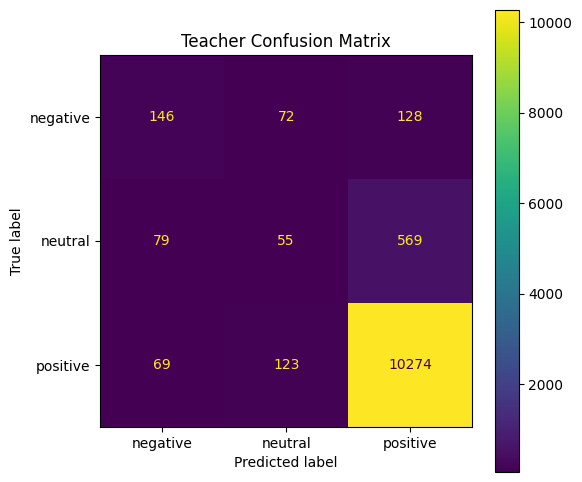


Saved per-review predictions to: /content/scored_test_predictions.csv

Scored sample (8 rows):


,reviews.id,item_id,true_label,pred_label,pred_conf,text_snippet
0,NaN,B01AHB9C1E,positive,positive,0.858114,I like the bigger screen.. My grandkids play o...
1,NaN,B01AHB9C1E,positive,positive,0.847217,The kindle fire HD 8 is really great!. It has ...
2,NaN,B01AHB9C1E,positive,positive,0.831285,Great tablet. Fast fun tablet with great speak...
3,NaN,B01AHB9C1E,positive,positive,0.844974,Awesome product. Easy-to-use. Lots of books ob...
4,NaN,B01AHB9C1E,positive,positive,0.753793,Love it. I have always had a kindle fire but I...
5,NaN,B01AHB9C1E,negative,negative,0.607101,Not really statisfied with features. Dont have...
6,NaN,B01AHB9C1E,positive,positive,0.790044,"Nice tablet, great price.. My husband's previo..."
7,NaN,B01AHB9C1E,neutral,positive,0.666329,amazon fire hd8. meh. it works. i find it diff...


In [ ]:
# BUILD SCORED DF (robust) — uses test_df for item_id/text/review id
# Requires: trainer, test_ds, test_df, id2label, SEED (optional)

import numpy as np
import pandas as pd
import torch

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1) Predict
pred = trainer.predict(test_ds)
logits = pred.predictions
y_true = pred.label_ids

print("Logits any NaN?", np.isnan(logits).any(), "| any Inf?", np.isinf(logits).any())

probs = torch.softmax(torch.tensor(logits), dim=-1).numpy()
y_pred = probs.argmax(axis=-1)
pred_conf = probs.max(axis=-1)

# 2) Sanity check alignment
print("len(test_ds):", len(test_ds), "| len(test_df):", len(test_df), "| len(preds):", len(y_pred))
assert len(test_df) == len(test_ds) == len(y_pred), "Row mismatch: test_df/test_ds/preds not aligned."

# 3) Metrics
labels_order = [0, 1, 2]
target_names = [id2label[i] for i in labels_order]

print("\nClassification report:")
print(classification_report(
    y_true, y_pred,
    labels=labels_order,
    target_names=target_names,
    digits=4,
    zero_division=0
))

cm = confusion_matrix(y_true, y_pred, labels=labels_order)
print("Confusion matrix:\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, values_format="d")
plt.title("Teacher Confusion Matrix")
plt.show()

# 4) Build scored from test_df (source of truth for text/item)
scored = test_df.copy().reset_index(drop=True)

# Ensure we have text + item_id columns; if names differ, adapt here:
TEXT_COL = "text_model"
ITEM_COL = "item_id"

assert TEXT_COL in scored.columns, f"Missing text column '{TEXT_COL}' in test_df. Found: {list(scored.columns)[:20]}..."
assert ITEM_COL in scored.columns, f"Missing item_id column '{ITEM_COL}' in test_df. Found: {list(scored.columns)[:20]}..."

# Review id: use reviews.id if present, else create one
if "reviews.id" not in scored.columns:
    scored["reviews.id"] = np.arange(len(scored))

# Attach predictions
scored["true_label_id"] = y_true
scored["pred_label_id"] = y_pred
scored["true_label"] = scored["true_label_id"].map(id2label)
scored["pred_label"] = scored["pred_label_id"].map(id2label)
scored["pred_conf"] = pred_conf

scored["prob_negative"] = probs[:, 0]
scored["prob_neutral"]  = probs[:, 1]
scored["prob_positive"] = probs[:, 2]

# Snippet for display
def snippet(x, n=220):
    x = "" if x is None else str(x)
    x = x.replace("\n", " ").strip()
    return x[:n] + ("..." if len(x) > n else "")

scored["text_snippet"] = scored[TEXT_COL].apply(snippet)

OUT_PATH = "/content/scored_test_predictions.csv"
scored.to_csv(OUT_PATH, index=False)
print(f"\nSaved per-review predictions to: {OUT_PATH}")

print("\nScored sample (8 rows):")
display(scored[["reviews.id", ITEM_COL, "true_label", "pred_label", "pred_conf", "text_snippet"]].head(8))


 Top 5 most confident predicted negative, neatral and positive reviews.

In [ ]:
# TOP-5 MOST CONFIDENT PER *PREDICTED* CLASS (NEG/NEU/POS)

import pandas as pd
from IPython.display import display, Markdown

# widen display
pd.set_option("display.width", 2000)
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_colwidth", 800)

# longer snippet
TEXT_COL = "text_model"  # change only if needed
def snippet(x, n=800):
    x = "" if x is None else str(x)
    x = x.replace("\n", " ").strip()
    return x[:n] + ("..." if len(x) > n else "")

scored["text_snippet_long"] = scored[TEXT_COL].apply(lambda t: snippet(t, n=800))

# product name column (optional)
CANDIDATE_PRODUCT_NAME_COLS = ["product_title", "product_name", "title", "name", "reviews.title", "summary"]
PROD_NAME_COL = next((c for c in CANDIDATE_PRODUCT_NAME_COLS if c in scored.columns), None)

SHOW = ["item_id"]
if PROD_NAME_COL:
    SHOW.append(PROD_NAME_COL)
SHOW += ["true_label", "pred_label", "pred_conf", "text_snippet_long"]

def show_top(sentiment: str, n: int = 5):
    sub = scored[scored["pred_label"] == sentiment].sort_values("pred_conf", ascending=False)

    # bold header + extra space
    display(Markdown(f"**Top {n} most confident PREDICTED '{sentiment.upper()}' reviews:**"))
    if len(sub) == 0:
        display(Markdown("_None predicted._"))
    else:
        display(sub[SHOW].head(n))

    # spacing between tables
    display(Markdown("<br><br>"))

show_top("negative", 5)
show_top("neutral",  5)
show_top("positive", 5)


**Top 5 most confident PREDICTED 'NEGATIVE' reviews:**

,item_id,name,true_label,pred_label,pred_conf,text_snippet_long
5157,B018Y229OU,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta",negative,negative,0.679900,"Not able to downloan app. We bought the tablet for work, but the only app we needed (free) never would download. After many tries and several hours, we gave up and took it back to the store."
10921,B018Y229OU,"Brand New Amazon Kindle Fire 16gb 7 Ips Display Tablet Wifi 16 Gb Blue,,,",neutral,negative,0.676602,"Shuts down randomly. I wouldn't buy again, had trouble w/shutting off all the time, we would have it reset back to the factory reset status and it would lock up and freeze, actually replaced with second thinking that was just a bad one however sad to report same problems. Not a favorite purchase."
7126,B018Y229OU,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta",negative,negative,0.665901,Didn't connect to wifi. I was setting up 2 of the same tablet and this one wouldn't connect to the wifi. When I brought it back for an exchange there were none in store and they didn't even have them on their website! Ended up getting a refund and purchasing the same model from Amazon
5119,B018Y229OU,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta",negative,negative,0.662296,"It was faulty, had to contact Amazon. The one purchased at Best Buy had black and gray lines appearing across the screen when powering up. It got worse, to occurring while using it. Amazon was contacted via Chat and determined something was wrong, and exchanged it. The replacement from Amazon is working, so for this I will mark, ""Yes"" to recommend it."
1646,B018Y229OU,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta",negative,negative,0.661167,"Didn't work first time powered on. The first time I buy my first tablet it came on but it only showed that it needed to reeboot, it then shut off by its self."


<br><br>

**Top 5 most confident PREDICTED 'NEUTRAL' reviews:**

,item_id,name,true_label,pred_label,pred_conf,text_snippet_long
10743,B018Y229OU,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta",neutral,neutral,0.536530,Kind of slow but decent overall. I don't care for the lack of storage or the strange arrangement and naviagation through the software. Nonetheless it's nice for its price
8209,B018Y229OU,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta",positive,neutral,0.528120,The camera is ok. This is ok for kids but the camera is not bright enough.
10041,B018Y229OU,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta",negative,neutral,0.507881,It was average. Purchased for my kids but it was hard to navigate and ended up with purchasing an iPad
9913,B018Y229OU,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta",negative,neutral,0.498979,You get what you pay for.. Wanted a cheap tablet to read books and comics. I found the lack of apps to be disappointing. It seems the tabelt is designed to make one buy books from amazon or to buy apps.
4275,B018Y229OU,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta",positive,neutral,0.495424,"Cheap, small and slow. It's continent for my son but is too slow to connect to wifi"


<br><br>

**Top 5 most confident PREDICTED 'POSITIVE' reviews:**

,item_id,name,true_label,pred_label,pred_conf,text_snippet_long
10137,B018Y229OU,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta",positive,positive,0.885836,Loving it!. So far so good I am absolutely loving this tablet and its durability . neat features and abilities for the price!
7618,B018Y229OU,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta",positive,positive,0.883768,"Convenient, Efficient. Perfect size, works great, great streaming quality."
2616,B018Y229OU,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta",positive,positive,0.881662,Works great. Great for kids. Simple to use and a variety of apps.
6714,B018Y229OU,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta",positive,positive,0.881608,"Great Deal. Love mine so Bought the grandkids once each for Christmas they love them. Good games, books and movies."
7924,B018Y229OU,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta",positive,positive,0.881353,great item. I love it! We have them for all our children and they love them


<br><br>

TOP 5 : Each product

In [ ]:
# TOP-5 PER SENTIMENT, EACH FROM A DIFFERENT PRODUCT (item_id)
from IPython.display import display, Markdown
import pandas as pd

pd.set_option("display.width", 2000)
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_colwidth", 800)

SHOW = ["item_id"]
if "name" in scored.columns:
    SHOW.append("name")
SHOW += ["true_label", "pred_label", "pred_conf", "text_snippet_long"]

def top_unique_products(sentiment: str, n: int = 5):
    sub = scored[scored["pred_label"] == sentiment].sort_values("pred_conf", ascending=False)

    # keep only the top row per item_id
    sub_unique = sub.drop_duplicates(subset=["item_id"], keep="first")

    display(Markdown(f"**Top {n} most confident PREDICTED '{sentiment.upper()}' reviews (unique products):**"))
    if len(sub_unique) == 0:
        display(Markdown("_None predicted._"))
    else:
        display(sub_unique[SHOW].head(n))

    display(Markdown("<br><br>"))

top_unique_products("negative", 5)
top_unique_products("neutral", 5)
top_unique_products("positive", 5)


**Top 5 most confident PREDICTED 'NEGATIVE' reviews (unique products):**

,item_id,name,true_label,pred_label,pred_conf,text_snippet_long
5157,B018Y229OU,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta",negative,negative,0.679900,"Not able to downloan app. We bought the tablet for work, but the only app we needed (free) never would download. After many tries and several hours, we gave up and took it back to the store."
11027,B01AHB9C1E,"Fire HD 8 Tablet with Alexa, 8"" HD Display, 32 GB, Tangerine - with Special Offers",negative,negative,0.619541,"less than 120 days, about 100 use. It is toast!. Bought this mostly as a backup.and to read a few books, since I have a larger cell phone and a back up. Used it occasionally may 40 or 50 hours of use till this week when I sent my laptop in for repairs. so I probably used it a tot this week. I was watching my 3rd Primetime video this week and it simply turned off. It will not turn on using any power trick such as safe mode. It is gone, It is toast. Bought it October 11, 2016 , It quit on February 9, 2015. My old Fire lasted 4 or 5 years with more use. it had stereo speakers, lasted a week on a charge not 2 or 3 days.Sturdier built. This is full of junk, I am not just offered more apps, it is constantly trying to add them. JUNK JUNK JUNK"
11257,B01J94T1Z2,"All-New Fire HD 8 Tablet with Alexa, 8 HD Display, 32 GB, Marine Blue - with Special Offers",negative,negative,0.609085,"Doesn't work for me. This is my 4th Kindle, and the worst so far. It randomly locks up and require a restart to do anything. I've probably had to do this a dozen times in the last week. It's going back if they'll take it."
11072,B006BGZJJ4,Amazon Kindle Charger Power Adapter Wall Charger And Usb Cable Micro Usb Cord,negative,negative,0.570285,"Problems with both Kindle mini-USB cord and mini-USB plug on the device. When I got my Kindle Fire, I got a protective cover for it and figured I'd be ok, because I don't travel much at all (am bedridden/disabled from car accidents). After a while, I couldn't get the mini-USB cord to stay in the plug on the Kindle. After describing the problem to Amazon, they sent me a new cord (I got the newer one with an AC plug and had to pay for it). Unfortunately this did not solve the problem, and I had to mail them my Kindle, and they shipped me a new one, configured mostly the way I had everything before I sent it, which was very convenient. Using my new cable (purchased through the Amazon Kindle store), I had no problems, at first.With only very light use, primarily for reading books for short..."
11218,B01J94SWWU,"Amazon Fire HD 8 with Alexa (8"" HD Display Tablet)",negative,negative,0.508538,Not to be modified. I don‚Äôt care that you can‚Äôt change the tablet to run like as you wish. It‚Äôs pre installed menu is not something you can change.


<br><br>

**Top 5 most confident PREDICTED 'NEUTRAL' reviews (unique products):**

,item_id,name,true_label,pred_label,pred_conf,text_snippet_long
10743,B018Y229OU,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta",neutral,neutral,0.536530,Kind of slow but decent overall. I don't care for the lack of storage or the strange arrangement and naviagation through the software. Nonetheless it's nice for its price
11379,B01J94T1Z2,"All-New Fire HD 8 Tablet with Alexa, 8 HD Display, 32 GB, Marine Blue - with Special Offers",positive,neutral,0.461718,"Sounds Poor and internet reception fair to poor. Quite complex and troublesome, with poor features. It does not store music or file and keep ponying to various sites"
11117,B01J94SWWU,"Amazon Fire HD 8 with Alexa (8"" HD Display Tablet)",positive,neutral,0.453751,"Can't beat the features for the money. While there are many budget tablets out there, not all of them are functional. This one is. If you are part of the Amazon universe this links seamlessly. Book purchases sync without effort. Movies are easy to see on Amazon Prime and you can use Netflix also. Alexa is an added bonus. Not sure the camera will get much use but it is there if you want it. Amazon is slowly opening up their market place to other popular apps so expect more. (Note: I turned off the WiFi and just used this as an e-reader and didn't have to charge it for almost 2 weeks!)"
11475,B01AHB9C1E,"Fire HD 8 Tablet with Alexa, 8 HD Display, 32 GB, Tangerine - with Special Offers",positive,neutral,0.436130,I was expecting more. It's great to some extent but I was expecting more. It's unfortunate that it does not work with lots of apps. Perhaps I'm not using them correctly. I'm still learning.
11413,B06XD5YCKX,"All-New Kindle Oasis E-reader - 7 High-Resolution Display (300 ppi), Waterproof, Built-In Audible, 8 GB, Wi-Fi - Includes Special Offers",positive,neutral,0.433022,Very nice but like older generation better. Kind of disappointed that they did away with the included battery cover and also removed the ability to even connect a battery cover.


<br><br>

**Top 5 most confident PREDICTED 'POSITIVE' reviews (unique products):**

,item_id,name,true_label,pred_label,pred_conf,text_snippet_long
10137,B018Y229OU,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta",positive,positive,0.885836,Loving it!. So far so good I am absolutely loving this tablet and its durability . neat features and abilities for the price!
11284,B01J94T1Z2,"All-New Fire HD 8 Tablet with Alexa, 8 HD Display, 32 GB, Marine Blue - with Special Offers",positive,positive,0.879963,Great gift. My wife loves it and the Alexa feature is incredible
11086,B00REQKWGA,"Kindle Oasis E-reader with Leather Charging Cover - Black, 6 High-Resolution Display (300 ppi), Wi-Fi - Includes Special Offers",positive,positive,0.876604,Great entertainment. The new Kindle is a great gift and fantastic entertainment idea.
11505,B01AHB9C1E,"Fire HD 8 Tablet with Alexa, 8 HD Display, 32 GB, Tangerine - with Special Offers",positive,positive,0.876596,"techy kids will like. great kid friendly product, hours of enjoyment for all."
11205,B01J94SWWU,"Amazon Fire HD 8 with Alexa (8"" HD Display Tablet)",positive,positive,0.875029,"Love It. I bought this for my daughter. She loves it. Great value, and easy to use!"


<br><br>

Pre-website layout (single catagory)

In [ ]:
# 3 PRODUCTS × 3 SENTIMENTS GRID (each row = different item_id)
import numpy as np
import pandas as pd

def pick_best(pid, sentiment):
    sub = scored[(scored["item_id"] == pid) & (scored["pred_label"] == sentiment)].sort_values("pred_conf", ascending=False)
    if len(sub) == 0:
        return "—"
    r = sub.iloc[0]
    return f"p={r['pred_conf']:.2f} (true={r['true_label']}) {r['text_snippet_long']}"

# pick 3 products with lots of reviews (more likely to have all sentiments)
top_products = scored["item_id"].value_counts().head(50).index.tolist()

rows = []
for pid in top_products:
    rows.append({
        "item_id": pid,
        "name": scored.loc[scored["item_id"] == pid, "name"].iloc[0] if "name" in scored.columns else "",
        "negative_review": pick_best(pid, "negative"),
        "neutral_review": pick_best(pid, "neutral"),
        "positive_review": pick_best(pid, "positive"),
    })
    if len(rows) == 3:
        break

grid = pd.DataFrame(rows)
display(grid)


,item_id,name,negative_review,neutral_review,positive_review
0,B018Y229OU,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta","p=0.68 (true=negative) Not able to downloan app. We bought the tablet for work, but the only app we needed (free) never would download. After many tries and several hours, we gave up and took it back to the store.",p=0.54 (true=neutral) Kind of slow but decent overall. I don't care for the lack of storage or the strange arrangement and naviagation through the software. Nonetheless it's nice for its price,p=0.89 (true=positive) Loving it!. So far so good I am absolutely loving this tablet and its durability . neat features and abilities for the price!
1,B01AHB9C1E,"Fire HD 8 Tablet with Alexa, 8 HD Display, 32 GB, Tangerine - with Special Offers,","p=0.62 (true=negative) less than 120 days, about 100 use. It is toast!. Bought this mostly as a backup.and to read a few books, since I have a larger cell phone and a back up. Used it occasionally may 40 or 50 hours of use till this week when I sent my laptop in for repairs. so I probably used it a tot this week. I was watching my 3rd Primetime video this week and it simply turned off. It will not turn on using any power trick such as safe mode. It is gone, It is toast. Bought it October 11, 2016 , It quit on February 9, 2015. My old Fire lasted 4 or 5 years with more use. it had stereo speakers, lasted a week on a charge not 2 or 3 days.Sturdier built. This is full of junk, I am not just offered more apps, it is constantly trying to add them. JUNK JUNK JUNK",p=0.44 (true=positive) I was expecting more. It's great to some extent but I was expecting more. It's unfortunate that it does not work with lots of apps. Perhaps I'm not using them correctly. I'm still learning.,"p=0.88 (true=positive) techy kids will like. great kid friendly product, hours of enjoyment for all."
2,B01J94T1Z2,"All-New Fire HD 8 Tablet with Alexa, 8 HD Display, 32 GB, Marine Blue - with Special Offers","p=0.61 (true=negative) Doesn't work for me. This is my 4th Kindle, and the worst so far. It randomly locks up and require a restart to do anything. I've probably had to do this a dozen times in the last week. It's going back if they'll take it.","p=0.46 (true=positive) Sounds Poor and internet reception fair to poor. Quite complex and troublesome, with poor features. It does not store music or file and keep ponying to various sites",p=0.88 (true=positive) Great gift. My wife loves it and the Alexa feature is incredible


 ## **Bonous**: Model Gives its **own** star rating to reviews.

In [ ]:
import pandas as pd
import numpy as np

# Wider pandas display (helps in Colab tables)
pd.set_option("display.width", 3000)
pd.set_option("display.max_columns", 80)
pd.set_option("display.max_colwidth", 1200)

# Rebuild the text with a clear separator (you can change the separator string)
SEP = "  | User Review: "   # visual gap

# Calculate model_star_rating_ui for the scored DataFrame
scored["model_star_rating_ui"] = (
    1.0 * scored["prob_negative"] +
    3.0 * scored["prob_neutral"] +
    5.0 * scored["prob_positive"]
).round(1)

def pick_best_with_stars_gap(pid, sentiment):
    sub = scored[(scored["item_id"] == pid) & (scored["pred_label"] == sentiment)].sort_values("pred_conf", ascending=False)
    if len(sub) == 0:
        return "—"
    r = sub.iloc[0]

    model_stars = f"{r['model_star_rating_ui']:.1f}★"
    actual_stars = f"{r['reviews.rating']}★" if "reviews.rating" in scored.columns else "N/A"

    stats = f"Model={model_stars} | Actual={actual_stars} | p={r['pred_conf']:.2f} | true={r['true_label']}"
    review = r["text_snippet_long"] if "text_snippet_long" in scored.columns else str(r["text_model"])

    return stats + SEP + review

# Recreate the same 3 products you already showed (use top frequency again)
top_products = scored["item_id"].value_counts().head(50).index.tolist()

rows = []
for pid in top_products:
    rows.append({
        "item_id": pid,
        "name": scored.loc[scored["item_id"] == pid, "name"].iloc[0] if "name" in scored.columns else "",
        "negative_review": pick_best_with_stars_gap(pid, "negative"),
        "neutral_review": pick_best_with_stars_gap(pid, "neutral"),
        "positive_review": pick_best_with_stars_gap(pid, "positive"),
    })
    if len(rows) == 3:
        break

grid_stars_gap = pd.DataFrame(rows)
display(grid_stars_gap)


,item_id,name,negative_review,neutral_review,positive_review
0,B018Y229OU,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta","Model=1.9★ | Actual=2.0★ | p=0.68 | true=negative | User Review: Not able to downloan app. We bought the tablet for work, but the only app we needed (free) never would download. After many tries and several hours, we gave up and took it back to the store.",Model=3.1★ | Actual=3.0★ | p=0.54 | true=neutral | User Review: Kind of slow but decent overall. I don't care for the lack of storage or the strange arrangement and naviagation through the software. Nonetheless it's nice for its price,Model=4.7★ | Actual=5.0★ | p=0.89 | true=positive | User Review: Loving it!. So far so good I am absolutely loving this tablet and its durability . neat features and abilities for the price!
1,B01AHB9C1E,"Fire HD 8 Tablet with Alexa, 8 HD Display, 32 GB, Tangerine - with Special Offers,","Model=2.1★ | Actual=1.0★ | p=0.62 | true=negative | User Review: less than 120 days, about 100 use. It is toast!. Bought this mostly as a backup.and to read a few books, since I have a larger cell phone and a back up. Used it occasionally may 40 or 50 hours of use till this week when I sent my laptop in for repairs. so I probably used it a tot this week. I was watching my 3rd Primetime video this week and it simply turned off. It will not turn on using any power trick such as safe mode. It is gone, It is toast. Bought it October 11, 2016 , It quit on February 9, 2015. My old Fire lasted 4 or 5 years with more use. it had stereo speakers, lasted a week on a charge not 2 or 3 days.Sturdier built. This is full of junk, I am not just offered more apps, it is constantly trying to add them. JUNK JUNK JUNK",Model=3.0★ | Actual=4.0★ | p=0.44 | true=positive | User Review: I was expecting more. It's great to some extent but I was expecting more. It's unfortunate that it does not work with lots of apps. Perhaps I'm not using them correctly. I'm still learning.,"Model=4.7★ | Actual=4.0★ | p=0.88 | true=positive | User Review: techy kids will like. great kid friendly product, hours of enjoyment for all."
2,B01J94T1Z2,"All-New Fire HD 8 Tablet with Alexa, 8 HD Display, 32 GB, Marine Blue - with Special Offers","Model=2.1★ | Actual=1.0★ | p=0.61 | true=negative | User Review: Doesn't work for me. This is my 4th Kindle, and the worst so far. It randomly locks up and require a restart to do anything. I've probably had to do this a dozen times in the last week. It's going back if they'll take it.","Model=3.1★ | Actual=4.0★ | p=0.46 | true=positive | User Review: Sounds Poor and internet reception fair to poor. Quite complex and troublesome, with poor features. It does not store music or file and keep ponying to various sites",Model=4.7★ | Actual=5.0★ | p=0.88 | true=positive | User Review: Great gift. My wife loves it and the Alexa feature is incredible


 ## **Catagory Building**

In [ ]:
import re
import pandas as pd
import numpy as np

assert "df" in globals(), "df not found. Load user_reviews.csv first."

def assign_category_3(name: str) -> str:
    s = ("" if pd.isna(name) else str(name)).lower()

    # normalize common messy patterns
    s = s.replace("\r\n", " ").replace("\\r\\n", " ")
    s = re.sub(r"\s+", " ", s).strip()

    # --- Bucket 1: Tablets & eReaders ---
    if any(k in s for k in [
        "fire tablet", "fire hd", "kindle", "paperwhite", "voyage", "ereader", "e-reader", "tablet"
    ]):
        return "Tablets & eReaders"

    # --- Bucket 2: Smart Home & Audio ---
    if any(k in s for k in [
        "echo", "echo dot", "alexa", "fire tv", "tv stick", "speaker", "sound"
    ]):
        return "Smart Home & Audio"

    # --- Bucket 3: Accessories & Consumables ---
    if any(k in s for k in [
        "battery", "batteries", "amazonbasics", "charger", "power adapter", "adapter",
        "case", "cover", "protective", "cable", "usb"
    ]):
        return "Accessories & Consumables"

    return "Accessories & Consumables"  # default fallback for demo

# add placeholder category
df["demo_category"] = df["name"].apply(assign_category_3)

print("demo_category value counts:")
display(df["demo_category"].value_counts())

print("\nExample rows:")
display(df[["name", "demo_category"]].drop_duplicates().head(20))


demo_category value counts:


,count
demo_category,
Tablets & eReaders,34379
Accessories & Consumables,16087
Smart Home & Audio,7669



Example rows:


,name,demo_category
0,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta",Tablets & eReaders
2814,"Kindle Oasis E-reader with Leather Charging Cover - Merlot, 6 High-Resolution Display (300 ppi), Wi-Fi - Includes Special Offers,,",Tablets & eReaders
2881,"Amazon Kindle Lighted Leather Cover,,,\r\nAmazon Kindle Lighted Leather Cover,,,",Tablets & eReaders
2883,"Amazon Kindle Lighted Leather Cover,,,\r\nKindle Keyboard,,,",Tablets & eReaders
2884,"Kindle Keyboard,,,\r\nKindle Keyboard,,,",Tablets & eReaders
2905,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 32 GB - Includes Special Offers, Magenta",Tablets & eReaders
3051,"Fire HD 8 Tablet with Alexa, 8 HD Display, 32 GB, Tangerine - with Special Offers,",Tablets & eReaders
3065,"Amazon 5W USB Official OEM Charger and Power Adapter for Fire Tablets and Kindle eReaders,,,\r\nAmazon 5W USB Official OEM Charger and Power Adapter for Fire Tablets and Kindle eReaders,,,",Tablets & eReaders
3266,"All-New Kindle E-reader - Black, 6 Glare-Free Touchscreen Display, Wi-Fi - Includes Special Offers,,",Tablets & eReaders
3478,"Amazon Kindle Fire Hd (3rd Generation) 8gb,,,\r\nAmazon Kindle Fire Hd (3rd Generation) 8gb,,,",Tablets & eReaders


DEMO Catagories (placeholder catagory set up for new dataset usage)

In [ ]:
import re
import pandas as pd
import numpy as np
from IPython.display import display, Markdown

pd.set_option("display.width", 4500)
pd.set_option("display.max_columns", 220)
pd.set_option("display.max_colwidth", 1600)

assert "scored" in globals(), "Run scoring so `scored` exists."
for col in ["name","item_id","pred_label","pred_conf","true_label","model_star_rating_ui"]:
    assert col in scored.columns, f"Missing in scored: {col}"

RATING_COL = "reviews.rating" if "reviews.rating" in scored.columns else None
SEP = "  | User Review: "

def clean_name(name):
    if pd.isna(name): return ""
    s = str(name).replace("\\r\\n", "\r\n").replace("\r\n", " ")
    s = re.sub(r"\s+", " ", s).strip()
    return s

def infer_demo_category(name: str) -> str:
    s = clean_name(name).lower()

    # Tablets & eReaders
    if any(k in s for k in ["fire tablet", "fire hd", "kindle", "paperwhite", "voyage", "ereader", "e-reader", "tablet"]):
        return "Tablets & eReaders"

    # Smart Home & Audio
    if any(k in s for k in ["echo dot", "echo", "alexa", "fire tv", "tv stick", "speaker", "soundbar", "audio", "streaming"]):
        return "Smart Home & Audio"

    # Accessories & Consumables
    if any(k in s for k in ["amazonbasics", "battery", "batteries", "charger", "power adapter", "adapter", "case", "cover", "protective", "usb", "cable"]):
        return "Accessories & Consumables"

    return "Accessories & Consumables"

sc = scored.copy()
sc["name_clean"] = sc["name"].apply(clean_name)
sc["demo_category"] = sc["name_clean"].apply(infer_demo_category)

print("Rows per demo_category (in SCORED predictions):")
display(sc["demo_category"].value_counts())

def format_row(r):
    model_stars = f"{r['model_star_rating_ui']:.1f}★"
    actual = f"{r[RATING_COL]}★" if RATING_COL else "N/A"
    stats = f"Model={model_stars} | Actual={actual} | p={r['pred_conf']:.2f} | true={r['true_label']}"
    review = r["text_snippet_long"] if "text_snippet_long" in sc.columns else str(r.get("text_model",""))
    return stats + SEP + review

def pick_candidate(df_pid, target):
    # primary: top confident predicted target
    sub = df_pid[df_pid["pred_label"] == target].sort_values("pred_conf", ascending=False)
    if len(sub) > 0:
        return sub.iloc[0]

    # fallback: choose closest-to-boundary review (lowest confidence overall)
    # This ensures each sentiment cell is populated for UI demo even if model didn't predict that class for this product.
    sub2 = df_pid.sort_values("pred_conf", ascending=True)
    return sub2.iloc[0] if len(sub2) else None

def choose_products_strict(df_cat, k=3):
    # STRICT: choose only products from this category, guaranteed non-empty if df_cat non-empty.
    # Prefer products with most reviews, and prefer those with diverse predicted labels.
    tmp = df_cat.groupby("item_id").agg(
        n_rows=("item_id","size"),
        n_labels=("pred_label","nunique")
    ).sort_values(["n_labels","n_rows"], ascending=False)

    chosen = tmp.index.tolist()[:k]

    # If somehow fewer than k products (rare), pad with remaining by frequency
    if len(chosen) < k:
        pad = df_cat["item_id"].value_counts().index.tolist()
        for pid in pad:
            if pid not in chosen:
                chosen.append(pid)
            if len(chosen) == k:
                break
    return chosen

categories = ["Tablets & eReaders", "Smart Home & Audio", "Accessories & Consumables"]

for cat in categories:
    df_cat = sc[sc["demo_category"] == cat].copy()

    display(Markdown(f"## **{cat}**"))
    print("Rows:", len(df_cat), "| unique products:", df_cat["item_id"].nunique())

    if len(df_cat) == 0:
        print("❌ No rows in this category inside `scored`. This means your scored subset doesn't include items for this bucket.")
        print("Fix: score more rows OR score the full dataset, not just the tablet slice.")
        display(Markdown("<br><br>"))
        continue

    chosen = choose_products_strict(df_cat, k=3)

    out = []
    for pid in chosen:
        df_pid = df_cat[df_cat["item_id"] == pid].copy()
        pname = df_pid["name_clean"].dropna()
        pname = pname.iloc[0] if len(pname) else ""

        neg = pick_candidate(df_pid, "negative")
        neu = pick_candidate(df_pid, "neutral")
        pos = pick_candidate(df_pid, "positive")

        out.append({
            "item_id": pid,
            "name": pname,
            "negative_review": format_row(neg) if neg is not None else "—",
            "neutral_review":  format_row(neu) if neu is not None else "—",
            "positive_review": format_row(pos) if pos is not None else "—",
        })

    display(pd.DataFrame(out))
    display(Markdown("<br><br>"))


Rows per demo_category (in SCORED predictions):


,count
demo_category,
Tablets & eReaders,11512
Smart Home & Audio,3


## **Tablets & eReaders**

Rows: 11512 | unique products: 7


,item_id,name,negative_review,neutral_review,positive_review
0,B018Y229OU,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta","Model=1.9★ | Actual=2.0★ | p=0.68 | true=negative | User Review: Not able to downloan app. We bought the tablet for work, but the only app we needed (free) never would download. After many tries and several hours, we gave up and took it back to the store.",Model=3.1★ | Actual=3.0★ | p=0.54 | true=neutral | User Review: Kind of slow but decent overall. I don't care for the lack of storage or the strange arrangement and naviagation through the software. Nonetheless it's nice for its price,Model=4.7★ | Actual=5.0★ | p=0.89 | true=positive | User Review: Loving it!. So far so good I am absolutely loving this tablet and its durability . neat features and abilities for the price!
1,B01AHB9C1E,"Fire HD 8 Tablet with Alexa, 8 HD Display, 32 GB, Tangerine - with Special Offers,","Model=2.1★ | Actual=1.0★ | p=0.62 | true=negative | User Review: less than 120 days, about 100 use. It is toast!. Bought this mostly as a backup.and to read a few books, since I have a larger cell phone and a back up. Used it occasionally may 40 or 50 hours of use till this week when I sent my laptop in for repairs. so I probably used it a tot this week. I was watching my 3rd Primetime video this week and it simply turned off. It will not turn on using any power trick such as safe mode. It is gone, It is toast. Bought it October 11, 2016 , It quit on February 9, 2015. My old Fire lasted 4 or 5 years with more use. it had stereo speakers, lasted a week on a charge not 2 or 3 days.Sturdier built. This is full of junk, I am not just offered more apps, it is constantly trying to add them. JUNK JUNK JUNK",Model=3.0★ | Actual=4.0★ | p=0.44 | true=positive | User Review: I was expecting more. It's great to some extent but I was expecting more. It's unfortunate that it does not work with lots of apps. Perhaps I'm not using them correctly. I'm still learning.,"Model=4.7★ | Actual=4.0★ | p=0.88 | true=positive | User Review: techy kids will like. great kid friendly product, hours of enjoyment for all."
2,B01J94T1Z2,"All-New Fire HD 8 Tablet with Alexa, 8 HD Display, 32 GB, Marine Blue - with Special Offers","Model=2.1★ | Actual=1.0★ | p=0.61 | true=negative | User Review: Doesn't work for me. This is my 4th Kindle, and the worst so far. It randomly locks up and require a restart to do anything. I've probably had to do this a dozen times in the last week. It's going back if they'll take it.","Model=3.1★ | Actual=4.0★ | p=0.46 | true=positive | User Review: Sounds Poor and internet reception fair to poor. Quite complex and troublesome, with poor features. It does not store music or file and keep ponying to various sites",Model=4.7★ | Actual=5.0★ | p=0.88 | true=positive | User Review: Great gift. My wife loves it and the Alexa feature is incredible


<br><br>

## **Smart Home & Audio**

Rows: 3 | unique products: 1


,item_id,name,negative_review,neutral_review,positive_review
0,B018Y229OU,"Certified Refurbished Amazon Fire TV (Previous Generation - 1st),,, Certified Refurbished Amazon Fire TV (Previous Generation - 1st),,,","Model=4.3★ | Actual=4.0★ | p=0.70 | true=positive | User Review: Great deal. I paid $35 for this unit right before Christmas. I have had an iPad mini2 for 3 years and this is not as user friendly, but for $35 now when traveling I have a 2nd streaming device. Perfect for kids/streaming.","Model=4.3★ | Actual=4.0★ | p=0.70 | true=positive | User Review: Great deal. I paid $35 for this unit right before Christmas. I have had an iPad mini2 for 3 years and this is not as user friendly, but for $35 now when traveling I have a 2nd streaming device. Perfect for kids/streaming.",Model=4.7★ | Actual=4.0★ | p=0.86 | true=positive | User Review: Great tablet for a child. Love the fact that it has parental controls to manage the tablet usage.


<br><br>

## **Accessories & Consumables**

Rows: 0 | unique products: 0
❌ No rows in this category inside `scored`. This means your scored subset doesn't include items for this bucket.
Fix: score more rows OR score the full dataset, not just the tablet slice.


<br><br>

## **Load New Dataset**: Zenodo Amazon Review Dataset
- Two data sets consisting of headphone reviews, I will stich them together.


In [ ]:
import pandas as pd
import numpy as np
import hashlib
from pathlib import Path

# ---- Find the CSVs (works whether they're in Colab root or same folder) ----
CANDIDATES_1 = [Path("AllProductReviews.csv"), Path("/content/AllProductReviews.csv"), Path("/mnt/data/AllProductReviews.csv")]
CANDIDATES_2 = [Path("AllProductReviews2.csv"), Path("/content/AllProductReviews2.csv"), Path("/mnt/data/AllProductReviews2.csv")]

def first_existing(paths):
    for p in paths:
        if p.exists():
            return str(p)
    raise FileNotFoundError(f"Could not find file in: {paths}")

P1 = first_existing(CANDIDATES_1)
P2 = first_existing(CANDIDATES_2)

df1 = pd.read_csv(P1, engine="python", on_bad_lines="skip")
df2 = pd.read_csv(P2, engine="python", on_bad_lines="skip")

print("Loaded:", P1, df1.shape, "cols:", list(df1.columns))
print("Loaded:", P2, df2.shape, "cols:", list(df2.columns))

# ---- Keep only what we need ----
# Standardize column names (ReviewBody is your text column)
df1 = df1.rename(columns={"ReviewStar":"rating", "Product":"product", "ReviewTitle":"title", "ReviewBody":"body"})
df2 = df2.rename(columns={"ReviewStar":"rating", "Product":"product", "ReviewTitle":"title", "ReviewBody":"body", "division":"label_str"})

# Ensure label_str exists in both
if "label_str" not in df1.columns: df1["label_str"] = np.nan
if "label_str" not in df2.columns: df2["label_str"] = np.nan

use_cols = ["rating","product","title","body","label_str"]
df = pd.concat([df1[use_cols], df2[use_cols]], ignore_index=True)

# ---- Clean text ----
df["title"] = df["title"].fillna("").astype(str)
df["body"]  = df["body"].fillna("").astype(str)
df["product"] = df["product"].fillna("Unknown").astype(str)

df["review_text"] = (df["title"].str.strip() + " " + df["body"].str.strip()).str.strip()
df = df[df["review_text"].str.len() > 0].copy()

# ---- Clean rating ----
df["rating"] = pd.to_numeric(df["rating"], errors="coerce")
df = df[df["rating"].between(1, 5)].copy()

# ---- Make stable IDs (hash of product + row index) ----
df["item_id"] = df["product"].apply(lambda s: hashlib.md5(s.encode("utf-8")).hexdigest()[:10])
df["review_id"] = np.arange(len(df))

print("\nFinal stitched df:", df.shape)
print("Unique products:", df["product"].nunique())
print(df["product"].value_counts().head(12))


Loaded: AllProductReviews.csv (14337, 4) cols: ['ReviewTitle', 'ReviewBody', 'ReviewStar', 'Product']
Loaded: AllProductReviews2.csv (9930, 5) cols: ['ReviewTitle', 'ReviewBody', 'ReviewStar', 'Product', 'division']

Final stitched df: (24267, 8)
Unique products: 10
product
boAt Rockerz 255         9995
Sennheiser CX 6.0BT      6628
JBL T110BT               2946
JBL T205BT               2819
PTron Intunes             508
Samsung EO-BG950CBEIN     447
Flybot Wave               363
Skullcandy S2PGHW-174     351
Flybot Boom               164
Flybot Beat                46
Name: count, dtype: int64


## Set Demo catagory for new dataset

In [ ]:
import re

def demo_category(product: str) -> str:
    p = product.lower()

    # Category 1: boAt + Flybot
    if ("boat" in p) or ("flybot" in p):
        return "boAt & Flybot"

    # Category 2: JBL + Sennheiser
    if ("jbl" in p) or ("sennheiser" in p):
        return "JBL & Sennheiser"

    # Category 3: everything else (PTron / Samsung / Skullcandy etc.)
    return "Other Brands"

df["demo_category"] = df["product"].apply(demo_category)

print("Demo category counts:")
print(df["demo_category"].value_counts())

print("\nUnique products per category:")
print(df.groupby("demo_category")["product"].nunique().sort_values(ascending=False))


Demo category counts:
demo_category
JBL & Sennheiser    12393
boAt & Flybot       10568
Other Brands         1306
Name: count, dtype: int64

Unique products per category:
demo_category
boAt & Flybot       4
JBL & Sennheiser    3
Other Brands        3
Name: product, dtype: int64


Check sentiment distribution

In [ ]:
def stars_to_label(stars: float) -> str:
    # Common mapping for review sentiment:
    # 1-2 negative, 3 neutral, 4-5 positive
    if stars <= 2:
        return "negative"
    if stars == 3:
        return "neutral"
    return "positive"

df["true_label"] = df["rating"].apply(stars_to_label)
print(df["true_label"].value_counts(normalize=True).round(4))


true_label
positive    0.5933
negative    0.2829
neutral     0.1239
Name: proportion, dtype: float64


In [ ]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# The ARTIFACT_DIR variable is not strictly needed if we use in-memory objects
# ARTIFACT_DIR = "/content/artifacts_teacher"

# Use the already loaded and trained teacher model and tokenizer
# `trainer.model` holds the best model after training due to load_best_model_at_end=True
model = trainer.model.to(device)
# The tokenizer was already initialized and used globally
# We ensure `tokenizer` refers to the teacher's tokenizer from previous steps

# The device was already determined globally
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device) # Already moved to device by trainer
model.eval()

# id2label and label2id are already available globally from preprocessing (cell f699ed36)
# id2label = model.config.id2label
# label2id = model.config.label2id
print("Labels:", id2label)

@torch.no_grad()
def predict_proba(texts, batch_size=32, max_length=256):
    probs_all = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        ).to(device)

        logits = model(**enc).logits
        probs = torch.softmax(logits, dim=-1).detach().cpu().numpy()
        probs_all.append(probs)

    return np.vstack(probs_all)

probs = predict_proba(df["review_text"].tolist(), batch_size=32, max_length=256)

# predicted label + confidence
pred_ids = probs.argmax(axis=1)
df["pred_label"] = [id2label[int(i)] for i in pred_ids]
df["pred_conf"]  = probs.max(axis=1)

# keep per-class probs for optional debugging
for lab, idx in label2id.items():
    df[f"p_{lab}"] = probs[:, idx]

print(df[["demo_category","product","rating","true_label","pred_label","pred_conf"]].head(5))


Labels: {0: 'negative', 1: 'neutral', 2: 'positive'}
   demo_category           product  rating true_label pred_label  pred_conf
0  boAt & Flybot  boAt Rockerz 255       3    neutral    neutral   0.360934
1  boAt & Flybot  boAt Rockerz 255       1   negative   negative   0.538149
2  boAt & Flybot  boAt Rockerz 255       4   positive   positive   0.533451
3  boAt & Flybot  boAt Rockerz 255       1   negative   negative   0.593814
4  boAt & Flybot  boAt Rockerz 255       5   positive   positive   0.396020


Check Models sentiment analysis with new dataset. + model star rating (column)

In [ ]:
SEP = "  | User Review: "

# Weighted expectation: 1★ (neg), 3★ (neu), 5★ (pos)
df["model_star"] = (
    1.0 * df.get("p_negative", 0) +
    3.0 * df.get("p_neutral", 0) +
    5.0 * df.get("p_positive", 0)
).round(1)

df["text_snippet_long"] = df["review_text"].str.replace(r"\s+", " ", regex=True).str.strip()

def format_row(r):
    return (
        f"Model={r['model_star']}★ | Actual={float(r['rating']):.1f}★ | "
        f"p={r['pred_conf']:.2f} | true={r['true_label']}{SEP}{r['text_snippet_long']}"
    )

df["pretty"] = df.apply(format_row, axis=1)

from sklearn.metrics import classification_report, confusion_matrix

y_true = df["true_label"].values
y_pred = df["pred_label"].values

print("Classification report:")
print(classification_report(y_true, y_pred, digits=4))

print("Confusion matrix [neg, neu, pos]:")
labels_order = ["negative", "neutral", "positive"]
print(confusion_matrix(y_true, y_pred, labels=labels_order))

SHOW_COLS = ["demo_category","product","rating","true_label","pred_label","pred_conf","model_star","text_snippet_long"]

def show_top(sentiment: str, n: int = 5):
    sub = df[df["pred_label"] == sentiment].sort_values("pred_conf", ascending=False)
    print("\n" + f"**Top {n} most confident PREDICTED '{sentiment.upper()}' reviews:**")
    if len(sub) == 0:
        print("(none)")
        return
    display(sub[SHOW_COLS].head(n))

show_top("negative", 5)
show_top("neutral", 5)
show_top("positive", 5)



Classification report:
              precision    recall  f1-score   support

    negative     0.6175    0.7010    0.6566      6864
     neutral     0.2551    0.1670    0.2018      3006
    positive     0.8208    0.8270    0.8239     14397

    accuracy                         0.7096     24267
   macro avg     0.5644    0.5650    0.5608     24267
weighted avg     0.6932    0.7096    0.6995     24267

Confusion matrix [neg, neu, pos]:
[[ 4812   628  1424]
 [ 1328   502  1176]
 [ 1653   838 11906]]

**Top 5 most confident PREDICTED 'NEGATIVE' reviews:**


,demo_category,product,rating,true_label,pred_label,pred_conf,model_star,text_snippet_long
68,boAt & Flybot,boAt Rockerz 255,1,negative,negative,0.694880,1.9,"Waste of money It is too bad..this ear phones could not completed even a month it has been only 20 days..and it's battery getting heated battery running time getting shorter by the time today it play only 1 hour ,next thing is it has been 5 days since it's one side earhone is not working..feeling cheated.."
14404,boAt & Flybot,boAt Rockerz 255,1,negative,negative,0.694880,1.9,"Waste of money It is too bad..this ear phones could not completed even a month it has been only 20 days..and it's battery getting heated battery running time getting shorter by the time today it play only 1 hour ,next thing is it has been 5 days since it's one side earhone is not working..feeling cheated.."
521,boAt & Flybot,boAt Rockerz 255,1,negative,negative,0.689019,1.9,Don't buy this product... After 45 days my Earphones are stopped working.. I tried to cliam my warranty but it boat team is not responding. I have registered my Earphones till now I have not received any confirmation email from them.. Worst experience from boat team.. Don't buy this product...
14857,boAt & Flybot,boAt Rockerz 255,1,negative,negative,0.689019,1.9,Don't buy this product... After 45 days my Earphones are stopped working.. I tried to cliam my warranty but it boat team is not responding. I have registered my Earphones till now I have not received any confirmation email from them.. Worst experience from boat team.. Don't buy this product...
2711,boAt & Flybot,boAt Rockerz 255,1,negative,negative,0.688320,1.9,"Battery problem Battery is not charging. Within one month of pruchase,it has started showing faults. Please consider other brands also before buying it."



**Top 5 most confident PREDICTED 'NEUTRAL' reviews:**


,demo_category,product,rating,true_label,pred_label,pred_conf,model_star,text_snippet_long
4284,boAt & Flybot,boAt Rockerz 255,3,neutral,neutral,0.540045,3.1,Didn't meet the expectation. Lightweight easy connection but it lacks the primary function that's quality sounding..
18616,boAt & Flybot,boAt Rockerz 255,3,neutral,neutral,0.540045,3.1,Didn't meet the expectation. Lightweight easy connection but it lacks the primary function that's quality sounding..
20796,JBL & Sennheiser,JBL T205BT,2,negative,neutral,0.529562,2.9,Good but nt as expected Should hv some arrangement to hold it on neck
6466,JBL & Sennheiser,JBL T205BT,2,negative,neutral,0.529562,2.9,Good but nt as expected Should hv some arrangement to hold it on neck
9912,JBL & Sennheiser,Sennheiser CX 6.0BT,5,positive,neutral,0.520545,3.0,Decent but pricey if not for the discount Material quality.Didn't seem quite like the material a top brand would use



**Top 5 most confident PREDICTED 'POSITIVE' reviews:**


,demo_category,product,rating,true_label,pred_label,pred_conf,model_star,text_snippet_long
21226,JBL & Sennheiser,JBL T205BT,5,positive,positive,0.876504,4.7,Value for money Very nice and compact product. Getting connected Seamlessly with my phone and laptop. Happily enjoying the product. An awesome product.
6899,JBL & Sennheiser,JBL T205BT,5,positive,positive,0.876504,4.7,Value for money Very nice and compact product. Getting connected Seamlessly with my phone and laptop. Happily enjoying the product. An awesome product.
9050,JBL & Sennheiser,Sennheiser CX 6.0BT,5,positive,positive,0.875903,4.7,Good one Loved the product.
10820,JBL & Sennheiser,Sennheiser CX 6.0BT,5,positive,positive,0.874937,4.7,Genuine one Nice & Comfortable.
3457,boAt & Flybot,boAt Rockerz 255,4,positive,positive,0.874149,4.7,Nice product. I m loving these. Bass is awesome! Its very comfortable. Sound quality is nice. I git this for 999/- and its worth it.


Set catagorys with new dataset

In [ ]:
from IPython.display import display, HTML
import pandas as pd

# Make tables wider + wrap long review text nicely
pd.set_option("display.max_colwidth", 220)
pd.set_option("display.width", 1600)

TABLE_CSS = """
<style>
  .cat-title{
    font-size: 22px; font-weight: 800;
    margin: 18px 0 6px 0;
  }
  .cat-sub{
    font-size: 13px; color: #666; margin-bottom: 10px;
  }

  table.dataframe{
    width: 100% !important;
    table-layout: fixed;          /* important */
  }

  table.dataframe th, table.dataframe td{
    vertical-align: top;
    padding: 10px 10px;
    word-wrap: break-word;
    white-space: pre-wrap;
  }

  table.dataframe th:nth-child(1),
  table.dataframe td:nth-child(1){ width: 110px !important; }   /* item_id */

  table.dataframe th:nth-child(2),
  table.dataframe td:nth-child(2){ width: 170px !important; }   /* name */

  table.dataframe th:nth-child(3),
  table.dataframe td:nth-child(3){ width: calc((100% - 280px) / 3) !important; }

  table.dataframe th:nth-child(4),
  table.dataframe td:nth-child(4){ width: calc((100% - 280px) / 3) !important; }

  table.dataframe th:nth-child(5),
  table.dataframe td:nth-child(5){ width: calc((100% - 280px) / 3) !important; }
</style>
"""

display(HTML(TABLE_CSS))

# ---- Controls ----
CATEGORIES = ["boAt & Flybot", "JBL & Sennheiser", "Other Brands"]
N_PRODUCTS_PER_CAT = 3

# If you want the same separator style:
SEP = "  | User Review: "

# ---- NEW: compact formatting helpers ----
def fmt_star(x):
    return f"{float(x):.1f}" if x is not None and pd.notna(x) else "—"

def fmt_prob(x):
    return f"{float(x):.2f}" if x is not None and pd.notna(x) else "—"

def make_pretty(row, actual_rating_col="reviews.rating"):
    """
    Builds the compact string:
    Model=4.3★ | Actual=5.0★ | p=0.89 | true=positive  | User Review: ...
    Works even if some columns are missing.
    """
    # model star: prefer existing computed column if you have it
    model_star = None
    for c in ["model_stars", "pred_stars", "model_star", "model_rating"]:
        if c in row and pd.notna(row[c]):
            model_star = row[c]
            break

    # actual star: your dataset might use different names
    actual_star = None
    for c in [actual_rating_col, "rating", "stars", "review_rating", "reviews.rating"]:
        if c in row and pd.notna(row[c]):
            actual_star = row[c]
            break

    # confidence: prefer pred_conf; otherwise max class prob if present
    conf = row["pred_conf"] if ("pred_conf" in row and pd.notna(row["pred_conf"])) else None
    if conf is None:
        probs = [row.get("p_negative", None), row.get("p_neutral", None), row.get("p_positive", None)]
        probs = [p for p in probs if p is not None and pd.notna(p)]
        if probs:
            conf = max(probs)

    true_label = row.get("true_label", "—")
    text = row.get("review_text", row.get("text_model", row.get("text", row.get("review", row.get("review_body", "")))))
    if pd.isna(text):
        text = ""

    return (
        f"Model={fmt_star(model_star)}★ | "
        f"Actual={fmt_star(actual_star)}★ | "
        f"p={fmt_prob(conf)} | "
        f"true={true_label}{SEP}{text}"
    )

def pick_one(product_df, target_sent):
    # Prefer predicted target sentiment with highest confidence
    m = product_df[product_df["pred_label"] == target_sent].sort_values("pred_conf", ascending=False)
    if len(m) > 0:
        return m.iloc[0]

    # Fallback: highest probability for that sentiment
    prob_col = f"p_{target_sent}"
    if prob_col in product_df.columns:
        m = product_df.sort_values(prob_col, ascending=False)
        if len(m) > 0:
            return m.iloc[0]

    return None

def build_grid_for_category(cat_df, n_products=3):
    # Choose products with enough reviews so we can fill sentiments
    candidate_products = cat_df["product"].value_counts().head(25).index.tolist()

    rows = []
    for prod in candidate_products:
        pdf = cat_df[cat_df["product"] == prod]

        neg = pick_one(pdf, "negative")
        neu = pick_one(pdf, "neutral")
        pos = pick_one(pdf, "positive")

        # Ensure each product row has all 3 cells filled
        if (neg is None) or (neu is None) or (pos is None):
            continue

        rows.append({
            "item_id": neg.get("item_id", "—"),
            "name": prod,
            # ---- CHANGED: use make_pretty to avoid long floats ----
            "negative_review": make_pretty(neg),
            "neutral_review":  make_pretty(neu),
            "positive_review": make_pretty(pos),
        })
        if len(rows) >= n_products:
            break

    return pd.DataFrame(rows)

# ---- Render categories with strong visual separation ----
for cat in CATEGORIES:
    cat_df = df[df["demo_category"] == cat].copy()

    display(HTML(f'<div class="cat-title">{cat}</div>'))
    display(HTML(f'<div class="cat-sub">Showing {N_PRODUCTS_PER_CAT} unique products × 3 sentiments (Model★ + Actual★ + confidence)</div>'))

    grid = build_grid_for_category(cat_df, n_products=N_PRODUCTS_PER_CAT)

    if len(grid) == 0:
        display(HTML("<b>No products found that can populate all 3 sentiments in this category.</b>"))
    else:
        display(grid)

    display(HTML("<br><br>"))


,item_id,name,negative_review,neutral_review,positive_review
0,e51ee53c4f,boAt Rockerz 255,Model=1.9★ | Actual=1.0★ | p=0.69 | true=negative | User Review: Waste of money It is too bad..this ear phones could not completed even a month it has been only 20 days..and it's battery getting heated battery runni...,Model=3.1★ | Actual=3.0★ | p=0.54 | true=neutral | User Review: Didn't meet the expectation. Lightweight easy connection but it lacks the primary function that's quality sounding..,Model=4.7★ | Actual=4.0★ | p=0.87 | true=positive | User Review: Nice product. I m loving these. Bass is awesome! Its very comfortable. Sound quality is nice. I git this for 999/- and its worth it.
1,17aaf25b26,Flybot Wave,"Model=1.9★ | Actual=1.0★ | p=0.67 | true=negative | User Review: Don't buy! Poor Quality Headphones First thing first, there is no bass at all only shrill treble. Bluetooth connectivity breaks down beyond 3 meters w...",Model=2.6★ | Actual=1.0★ | p=0.44 | true=negative | User Review: Don't buy this This is a cheap Chinese product. The sound and connectivity is also not good. One side of the earphone stopped working after one month ...,Model=4.7★ | Actual=4.0★ | p=0.86 | true=positive | User Review: Kadoos Gifted it for my little brother and he loved it. Got it in a deal price.
2,bc78f0e34c,Flybot Boom,Model=2.0★ | Actual=2.0★ | p=0.65 | true=negative | User Review: Value for money - NO Deep bass.. Huh! Don't get fooled pls.. Dissappointed by the bass seriously..,"Model=3.4★ | Actual=2.0★ | p=0.45 | true=negative | User Review: Not worth the price quoted The product as per its quality should be priced around 500-600 max. Sound quality not good, external noise is not minimized...","Model=4.7★ | Actual=5.0★ | p=0.87 | true=positive | User Review: very happy Very happy to buy this product,Good quality , everything is awesome thanx amazon."


,item_id,name,negative_review,neutral_review,positive_review
0,6d81dd3cce,Sennheiser CX 6.0BT,Model=1.9★ | Actual=2.0★ | p=0.68 | true=negative | User Review: Not durable Left head phone stopped working sfter 20 days.Poor response from Sennheiser customer support.,Model=3.0★ | Actual=5.0★ | p=0.52 | true=positive | User Review: Decent but pricey if not for the discount Material quality.Didn't seem quite like the material a top brand would use,Model=4.7★ | Actual=5.0★ | p=0.88 | true=positive | User Review: Good one Loved the product.
1,f5eac5140a,JBL T110BT,"Model=1.9★ | Actual=1.0★ | p=0.68 | true=negative | User Review: Wastage of money I buy this product on 13th Feb .2018,but after 1 year Left ear phone not working , the company told me it's a non repairable itemWas...","Model=2.9★ | Actual=2.0★ | p=0.51 | true=negative | User Review: Can't use for playing Games, lots of sound breaking The device creates a horrible sound when mic is on while playing games like PUBG on mobile. Also, ...",Model=4.7★ | Actual=5.0★ | p=0.87 | true=positive | User Review: Good👌🏻 Very good👌🏻
2,d6244867ff,JBL T205BT,Model=1.9★ | Actual=3.0★ | p=0.68 | true=neutral | User Review: Ok product Mine left ear headphone got non-functioning after few days. I believe will get it changed in the warranty.Decent headphone at price INR. 1899,Model=2.9★ | Actual=2.0★ | p=0.53 | true=negative | User Review: Good but nt as expected Should hv some arrangement to hold it on neck,Model=4.7★ | Actual=5.0★ | p=0.88 | true=positive | User Review: Value for money Very nice and compact product. Getting connected Seamlessly with my phone and laptop. Happily enjoying the product. An awesome product.


,item_id,name,negative_review,neutral_review,positive_review
0,9a5f9a0769,PTron Intunes,Model=1.9★ | Actual=1.0★ | p=0.67 | true=negative | User Review: Battery fault Battery back up 1 hour...,Model=2.8★ | Actual=1.0★ | p=0.48 | true=negative | User Review: Not a good product. Not advisable to buy,Model=4.7★ | Actual=5.0★ | p=0.87 | true=positive | User Review: Awesome product Awesome sound.i love the bass of it. Very high quality sound as I use dem on my I pod 5th gen.i recommend everyone to buy this.
1,8d846fd9a4,Samsung EO-BG950CBEIN,"Model=2.0★ | Actual=1.0★ | p=0.66 | true=negative | User Review: Not satisfy- Poor Product Mic is not working properly and bass also not there. so if u looking it for music, do not buy. There is no control on bass e...",Model=3.1★ | Actual=2.0★ | p=0.44 | true=negative | User Review: Not good just ordinary No bass and no anc. Not worthy for 4500,"Model=4.6★ | Actual=5.0★ | p=0.86 | true=positive | User Review: Great stuff Wonderful headphones, makes everything easy. Great sound quality, battery life and easy to use."
2,c164eff061,Skullcandy S2PGHW-174,Model=1.9★ | Actual=1.0★ | p=0.68 | true=negative | User Review: Won't stay for one months Damaged in 1 month.Wire used is not good & you can't cover it in warrty as it is a physical damage. 😂Don't buy. But I love s...,Model=2.9★ | Actual=4.0★ | p=0.48 | true=positive | User Review: Sound quality is good but product quality is not. Sound quality is good but product quality is not as good.,Model=4.6★ | Actual=5.0★ | p=0.86 | true=positive | User Review: Five Stars Works great!!


Prep for website export + remove new dataset duplicates.

In [ ]:
# =========================
# UI-ONLY de-duplication
# =========================
# Keep your original `scored` for metrics.
scored_ui = scored.copy()

# Choose the columns that define "same review" (tweak if needed)
DEDUP_KEYS = ["name", "text_snippet_long"]  # strongest for UI variety
# If you want stricter: include rating too
# DEDUP_KEYS = ["name", "rating", "text_snippet_long"]

# 1) Normalize text to reduce "cosmetic duplicates"
scored_ui["text_snippet_long_norm"] = (
    scored_ui["text_snippet_long"]
      .astype(str)
      .str.replace(r"\s+", " ", regex=True)
      .str.strip()
      .str.lower()
)

# Use normalized text in dedupe keys
dedup_keys_norm = [c for c in DEDUP_KEYS if c != "text_snippet_long"] + ["text_snippet_long_norm"]

# 2) Keep highest-confidence row per duplicate group
scored_ui = (
    scored_ui
    .sort_values("pred_conf", ascending=False)
    .drop_duplicates(subset=dedup_keys_norm, keep="first")
    .drop(columns=["text_snippet_long_norm"])
    .reset_index(drop=True)
)


Rows before UI dedupe: 11515
Rows after  UI dedupe: 11515


In [ ]:
# Build the same normalized key you used for dedupe
tmp = scored.copy()
tmp["norm"] = (
    tmp["text_snippet_long"].astype(str)
      .str.replace(r"\s+", " ", regex=True)
      .str.strip()
      .str.lower()
)

dup_mask = tmp.duplicated(subset=["name", "norm"], keep=False)
print("Duplicate rows by [product name + normalized text]:", int(dup_mask.sum()))

# Show a few duplicate groups (if any)
if dup_mask.any():
    display(tmp.loc[dup_mask, ["demo_category","name","rating","pred_label","pred_conf","text_snippet_long"]]
            .sort_values(["name","text_snippet_long"]).head(20))

Duplicate rows by [product name + normalized text]: 0


In [ ]:
import re

def strong_norm(s: str) -> str:
    s = str(s).lower()
    s = re.sub(r"\s+", " ", s)            # collapse whitespace
    s = re.sub(r"[^\w\s]", "", s)         # remove punctuation/symbols
    s = s.strip()
    return s

scored_ui = scored.copy()
scored_ui["norm"] = scored_ui["text_snippet_long"].map(strong_norm)

before = len(scored_ui)
scored_ui = (
    scored_ui.sort_values("pred_conf", ascending=False)
            .drop_duplicates(subset=["name","norm"], keep="first") # Changed 'product' to 'name'
            .drop(columns=["norm"])
            .reset_index(drop=True)
)
print("Rows before UI dedupe:", before)
print("Rows after  UI dedupe:", len(scored_ui))

Rows before UI dedupe: 11515
Rows after  UI dedupe: 11513


## Export JSON to website

In [ ]:
import pandas as pd
import numpy as np

# ---- choose which dataframe you are exporting ----
# try scored_ui first (preferred), else scored
dfw = scored_ui.copy() if "scored_ui" in globals() else scored.copy()

print("✅ Starting export from dfw with shape:", dfw.shape)
print("Columns:", list(dfw.columns))

# ---- helper: pick first existing column from candidates ----
def pick_col(candidates, cols):
    for c in candidates:
        if c in cols:
            return c
    return None

cols = set(dfw.columns)

# ---- auto-detect column names ----
COL_CATEGORY = pick_col(["demo_category", "category", "categories", "product_category", "main_category"], cols)
COL_PRODUCT  = pick_col(["name", "product", "title", "product_title"], cols)
COL_TEXT     = pick_col(["text_snippet_long", "review_text", "review", "review_body", "text", "content"], cols)

COL_PRED     = pick_col(["pred_label", "prediction", "pred"], cols)
COL_CONF     = pick_col(["pred_conf", "confidence", "conf"], cols)

COL_MSTARS   = pick_col(["model_stars", "model_star_rating", "pred_stars"], cols)
COL_ASTARS   = pick_col(["reviews.rating", "rating", "stars", "review_rating", "actual_stars"], cols)

print("\nDetected mapping:")
print("  category :", COL_CATEGORY)
print("  product  :", COL_PRODUCT)
print("  text     :", COL_TEXT)
print("  pred     :", COL_PRED)
print("  conf     :", COL_CONF)
print("  mstars   :", COL_MSTARS)
print("  astars   :", COL_ASTARS)

# ---- if category missing, create a simple one so export still works ----
if COL_CATEGORY is None:
    # simple fallback: bucket by product name keywords (you can tweak later)
    COL_CATEGORY = "demo_category"
    dfw[COL_CATEGORY] = "Other"

# ---- if product/text missing, fail fast with a clear message ----
if COL_PRODUCT is None or COL_TEXT is None or COL_PRED is None:
    raise ValueError(
        f"Missing required columns. Need product+text+pred.\n"
        f"Found product={COL_PRODUCT}, text={COL_TEXT}, pred={COL_PRED}.\n"
        f"Columns={list(dfw.columns)}"
    )

# ---- keep only columns that exist ----
keep_cols = [COL_CATEGORY, COL_PRODUCT, COL_TEXT, COL_PRED, COL_CONF, COL_MSTARS, COL_ASTARS]
keep_cols = [c for c in keep_cols if c is not None and c in dfw.columns]
dfw = dfw[keep_cols].copy()

# ---- drop rows missing the essentials (only those that exist) ----
essential = [COL_CATEGORY, COL_PRODUCT, COL_TEXT, COL_PRED]
essential = [c for c in essential if c in dfw.columns]
dfw = dfw.dropna(subset=essential)

# ---- clean up strings ----
dfw[COL_TEXT] = dfw[COL_TEXT].astype(str).str.strip()
dfw[COL_PRODUCT] = dfw[COL_PRODUCT].astype(str).str.strip()
dfw = dfw[dfw[COL_TEXT].str.len() > 0]
dfw = dfw[dfw[COL_PRODUCT].str.len() > 0]

print("\n✅ After cleanup:", dfw.shape)
display(dfw.head(3))

✅ Starting export from dfw with shape: (11513, 45)
Columns: ['id', 'name', 'asins', 'brand', 'categories', 'keys', 'manufacturer', 'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen', 'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id', 'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs', 'reviews.text', 'reviews.title', 'reviews.userCity', 'reviews.userProvince', 'reviews.username', 'source_file', 'dateAdded', 'dateUpdated', 'primaryCategories', 'imageURLs', 'manufacturerNumber', 'sourceURLs', 'title_clean', 'body_clean', 'text_model', 'item_id', 'rating', 'label', 'true_label_id', 'pred_label_id', 'true_label', 'pred_label', 'pred_conf', 'prob_negative', 'prob_neutral', 'prob_positive', 'text_snippet', 'text_snippet_long', 'model_star_rating_ui']

Detected mapping:
  category : categories
  product  : name
  text     : text_snippet_long
  pred     : pred_label
  conf     : pred_conf
  mstars   : None
  astars   : reviews.rating

✅ After cleanup: (11513, 6)


,categories,name,text_snippet_long,pred_label,pred_conf,reviews.rating
0,"Fire Tablets,Tablets,Computers & Tablets,All Tablets,Electronics, Tech Toys, Movies, Music,Electronics,iPad & Tablets,Android Tablets,Frys","Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta",Loving it!. So far so good I am absolutely loving this tablet and its durability . neat features and abilities for the price!,positive,0.885836,5.0
1,"Fire Tablets,Tablets,Computers & Tablets,All Tablets,Electronics, Tech Toys, Movies, Music,Electronics,iPad & Tablets,Android Tablets,Frys","Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta","Convenient, Efficient. Perfect size, works great, great streaming quality.",positive,0.883768,5.0
2,"Fire Tablets,Tablets,Computers & Tablets,All Tablets,Electronics, Tech Toys, Movies, Music,Electronics,iPad & Tablets,Android Tablets,Frys","Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta",Works great. Great for kids. Simple to use and a variety of apps.,positive,0.881662,5.0


## Save artifacts (teacher model + tokenizer + label map + metrics)

In [ ]:
from pathlib import Path
import json

ART_DIR = Path("./artifacts_teacher")
ART_DIR.mkdir(exist_ok=True)

trainer.model.save_pretrained(ART_DIR)
tokenizer.save_pretrained(ART_DIR)

with open(ART_DIR / "label_map.json", "w") as f:
    json.dump({"label2id": label2id, "id2label": id2label}, f, indent=2)

# Capture metrics after training
metrics = trainer.evaluate()

with open(ART_DIR / "metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("Saved artifacts to:", ART_DIR.resolve())

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Saved artifacts to: /content/artifacts_teacher


Collect user to AI difference form all reviews. Biased on AI sentiment dertmination.

In [ ]:
import os, re
import numpy as np
import pandas as pd
from transformers import pipeline
from tqdm.auto import tqdm

BASE="/content"
USER_PATH = os.path.join(BASE, "user_reviews.csv")
ALL_PATH1 = os.path.join(BASE, "AllProductReviews.csv")
ALL_PATH2 = os.path.join(BASE, "AllProductReviews2.csv")

def find_existing(*paths):
    for p in paths:
        if os.path.exists(p):
            return p
    raise FileNotFoundError(f"Missing files. /content has: {os.listdir('/content')}")

ALL_PATH = find_existing(ALL_PATH1, ALL_PATH2)
USER_PATH = find_existing(USER_PATH)

# ---- Set sentiment model (public model doesn't require HF_TOKEN) ----
MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment-latest"
sent = pipeline("sentiment-analysis", model=MODEL_NAME, device=0)  # GPU

def to_numeric_stars(x):
    if pd.isna(x): return np.nan
    m = re.search(r"(\d+(\.\d+)?)", str(x))
    return float(m.group(1)) if m else np.nan

def ai_stars_from_label(label, score):
    lab = str(label).upper()
    if "NEG" in lab: base = 1.5
    elif "POS" in lab: base = 4.5
    else: base = 3.0
    return float(np.clip(base + (float(score)-0.5)*0.6, 1.0, 5.0))

def add_ai_ratings(df, text_col, batch=64, max_chars=512):
    texts = (
        df[text_col]
        .fillna("")
        .astype(str)
        .str.replace("\n", " ")
        .str.slice(0, max_chars)
        .tolist()
    )
    preds = []
    for i in tqdm(range(0, len(texts), batch), desc=f"Scoring sentiment ({text_col})"):
        chunk = texts[i:i+batch]
        out = sent(chunk, truncation=True)
        preds.extend(out)

    df = df.copy()
    df["ai_rating"] = [ai_stars_from_label(p["label"], p["score"]) for p in preds]
    return df

def summary(df, label):
    delta = df["ai_rating"] - df["human_rating"]
    return {
        "label": label,
        "n_rows": int(len(df)),
        "mean_human": float(df["human_rating"].mean()),
        "mean_ai": float(df["ai_rating"].mean()),
        "mean_delta_ai_minus_human": float(delta.mean()),
        "median_delta": float(delta.median()),
        "mae": float(delta.abs().mean()),
        "rmse": float(np.sqrt((delta**2).mean())),
        "corr": float(df[["human_rating","ai_rating"]].corr().iloc[0,1]),
        "agree_within_0.5_star_pct": float((delta.abs()<=0.5).mean()*100),
        "agree_within_1.0_star_pct": float((delta.abs()<=1.0).mean()*100),
    }

def load_base(path):
    df = pd.read_csv(path, on_bad_lines="skip", engine="python")
    cols = set(df.columns)

    # --- Detect schema ---
    if "reviews.rating" in cols and "reviews.text" in cols:
        rating_col = "reviews.rating"
        text_col = "reviews.text"
    elif "ReviewStar" in cols and "ReviewBody" in cols:
        rating_col = "ReviewStar"
        text_col = "ReviewBody"
    else:
        raise ValueError(
            f"Unrecognized schema in {os.path.basename(path)}.\n"
            f"Columns: {list(df.columns)}\n"
            f"Expected either (reviews.rating + reviews.text) OR (ReviewStar + ReviewBody)."
        )

    out = df.copy()
    out["human_rating"] = out[rating_col].apply(to_numeric_stars)
    out = out.dropna(subset=["human_rating"]).reset_index(drop=True)

    return out, text_col

# ---- Load both ----
df_user, user_text_col = load_base(USER_PATH)
df_all,  all_text_col  = load_base(ALL_PATH)

# OPTIONAL quick test (uncomment if too slow)
# df_user = df_user.sample(5000, random_state=42).reset_index(drop=True)
# df_all  = df_all.sample(5000, random_state=42).reset_index(drop=True)

# ---- Score AI ratings ----
df_user_scored = add_ai_ratings(df_user, text_col=user_text_col)
df_all_scored  = add_ai_ratings(df_all,  text_col=all_text_col)

# ---- Combined ----
df_combined = pd.concat(
    [
        df_user_scored[["human_rating","ai_rating"]],
        df_all_scored[["human_rating","ai_rating"]],
    ],
    ignore_index=True
)

print(summary(df_user_scored[["human_rating","ai_rating"]], os.path.basename(USER_PATH)))
print(summary(df_all_scored[["human_rating","ai_rating"]], os.path.basename(ALL_PATH)))
print(summary(df_combined, "COMBINED (both files)"))

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: cardiffnlp/twitter-roberta-base-sentiment-latest
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.pooler.dense.weight     | UNEXPECTED |  | 
roberta.embeddings.position_ids | UNEXPECTED |  | 
roberta.pooler.dense.bias       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Scoring sentiment (reviews.text):   0%|          | 0/1062 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Scoring sentiment (ReviewBody):   0%|          | 0/225 [00:00<?, ?it/s]

{'label': 'user_reviews.csv', 'n_rows': 67959, 'mean_human': 4.556070571962507, 'mean_ai': 4.439688259211881, 'mean_delta_ai_minus_human': -0.11638231275062655, 'median_delta': -0.21426348686218244, 'mae': 0.5226224518507782, 'rmse': 0.7593705579629311, 'corr': 0.596491517280617, 'agree_within_0.5_star_pct': 67.39798996453744, 'agree_within_1.0_star_pct': 90.07342662487676}
{'label': 'AllProductReviews.csv', 'n_rows': 14337, 'mean_human': 3.675873613726721, 'mean_ai': 3.5822754024237016, 'mean_delta_ai_minus_human': -0.09359821130301968, 'median_delta': -0.21310970783233607, 'mae': 0.7570431699436513, 'rmse': 1.0383459722503816, 'corr': 0.7496753320840618, 'agree_within_0.5_star_pct': 46.13935969868173, 'agree_within_1.0_star_pct': 79.13091999721001}
{'label': 'COMBINED (both files)', 'n_rows': 82296, 'mean_human': 4.402729172742296, 'mean_ai': 4.290316137507641, 'mean_delta_ai_minus_human': -0.11241303523465566, 'median_delta': -0.2141412675380705, 'mae': 0.5634614942744381, 'rmse': 0

## Inference helper (returns label + probability)
This is the minimal function you’ll also reuse in the website backend.

In [ ]:
import torch
import numpy as np

@torch.no_grad()
def predict_sentiment(text: str, model, tok, max_len: int = 256):
    model.eval()
    inputs = tok(text, truncation=True, max_length=max_len, return_tensors="pt")
    inputs = {k:v.to(model.device) for k,v in inputs.items()}
    logits = model(**inputs).logits
    probs = torch.softmax(logits, dim=-1).cpu().numpy()[0]
    pred_id = int(np.argmax(probs))
    return {
        "label": id2label[pred_id],
        "prob": float(probs[pred_id]),
        "probs": {id2label[i]: float(probs[i]) for i in range(len(probs))}
    }

# quick smoke test:
sample_text = test_df["text_model"].iloc[0]
print("Sample text:", sample_text[:180], "...")
print(predict_sentiment(sample_text, trainer.model.to(device), tokenizer))